# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [2]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [6]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [7]:
try:
    path = snakemake.input.alignment
    dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
    tree_path = snakemake.input.tree
    if snakemake.input.clade_names is not None:
        clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
    f = open(snakemake.input.disease_name, "r")
    virus_name = f.read()
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


### Old Flu Files

In [3]:
#path = "../seasonal-flu-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = []
#tree_path = "../auspice/flu_seasonal_h3n2_ha_2y.json"
virus_name = "Flu"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Reading in all the data from the scripts

In [4]:
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [5]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [6]:
similarity_matrix = pd.read_csv("results/distance_matrix.csv", index_col=0)

In [7]:
similarity_matrix.columns = similarity_matrix.index

In [1]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/seasonal-flu-nextstrain'

In [94]:
node_df.head()

strain  num_date  pca1  pca2   mds1   mds2  tsne_x  \
0       A/Shiraz/1005/2015   2015.78 -1.20  3.03   5.68  -5.20  -13.70   
1  A/RobatKarim/21210/2016   2016.05 -1.53  4.35  -4.52  -7.25   -5.95   
2      A/Chungbuk/107/2016   2016.05 -1.56  5.09   1.95 -10.69   -6.62   
3  A/MUWRP-Uganda/579/2016   2016.67 -1.18  5.45 -15.09 -24.65   -7.04   
4       A/Shiraz/1011/2015   2015.89 -1.46  5.39   1.45  -0.85   -7.59   

   tsne_y  umap_x  umap_y clade_membership  y_value clade_membership_color  
0  -14.70    5.26    8.35              3c2        1                  other  
1  -46.27    5.61    8.61              3c2        2                  other  
2  -46.63    5.30    8.83              3c3        3                  other  
3  -46.56    3.95   18.42              3c3        4                  other  
4  -45.60    3.84   18.24            3c3.B        5                  other

In [35]:
node_df.shape

(1150, 13)

In [36]:
node_df.head()

strain     date  pca1  pca2   mds1   mds2  tsne_x  tsne_y  \
0       A/Shiraz/1005/2015  2015.78 -1.20  3.03   5.68  -5.20  -13.70  -14.70   
1  A/RobatKarim/21210/2016  2016.05 -1.53  4.35  -4.52  -7.25   -5.95  -46.27   
2      A/Chungbuk/107/2016  2016.05 -1.56  5.09   1.95 -10.69   -6.62  -46.63   
3  A/MUWRP-Uganda/579/2016  2016.67 -1.18  5.45 -15.09 -24.65   -7.04  -46.56   
4       A/Shiraz/1011/2015  2015.89 -1.46  5.39   1.45  -0.85   -7.59  -45.60   

   umap_x  umap_y clade_membership  y clade_membership_color  
0    5.26    8.35              3c2  1                  other  
1    5.61    8.61              3c2  2                  other  
2    5.30    8.83              3c3  3                  other  
3    3.95   18.42              3c3  4                  other  
4    3.84   18.24            3c3.B  5                  other

In [8]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [9]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

A/Brisbane/280/2016  A/Brisbane/302/2016  \
A/Brisbane/280/2016                        0                    2   
A/Brisbane/302/2016                        2                    0   
A/California/122/2016                      6                    4   
A/NewYork/57/2016                          5                    3   
A/Texas/178/2016                           6                    4   
...                                      ...                  ...   
A/Kenya/013/2017                          61                   59   
A/India/1736032/2017                      57                   55   
A/HongKong/3391/2017                      41                   39   
A/India/1732610/2017                      67                   65   
A/MUWRP-Uganda/579/2016                   35                   33   

                         A/California/122/2016  A/NewYork/57/2016  \
A/Brisbane/280/2016                          6                  5   
A/Brisbane/302/2016                          4                  3   
A/California/122/2016                        0                  3   
A/NewYork/57/2016                            3                  0   
A/Texas/178/2016                             6                  3   
...                                        ...                ...   
A/Kenya/013/2017                            59                 56   
A/India/1736032/2017                        55                 52   
A/HongKong/3391/2017                        39                 38   
A/India/1732610/2017                        65                 62   
A/MUWRP-Uganda/579/2016                     33                 32   

                         A/Texas/178/2016  A/Perth/22/2016  A/Sydney/142/2016  \
A/Brisbane/280/2016                     6                7                  6   
A/Brisbane/302/2016                     4                5                  4   
A/California/122/2016                   6                5                  8   
A/NewYork/57/2016                       3                4                  5   
A/Texas/178/2016                        0                7                  6   
...                                   ...              ...                ...   
A/Kenya/013/2017                       59               60                 61   
A/India/1736032/2017                   55               56                 57   
A/HongKong/3391/2017                   41               38                 43   
A/India/1732610/2017                   65               66                 66   
A/MUWRP-Uganda/579/2016                35               32                 37   

                         A/Brisbane/291/2016  A/Townsville/51/2016  \
A/Brisbane/280/2016                        6                     9   
A/Brisbane/302/2016                        4                     7   
A/California/122/2016                      8                    11   
A/NewYork/57/2016                          5                     8   
A/Texas/178/2016                           6                     9   
...                                      ...                   ...   
A/Kenya/013/2017                          61                    64   
A/India/1736032/2017                      57                    58   
A/HongKong/3391/2017                      43                    46   
A/India/1732610/2017                      67                    68   
A/MUWRP-Uganda/579/2016                   36                    39   

                         A/Idaho/33/2016  ...  A/Thailand/CU-B21722/2017  \
A/Brisbane/280/2016                    8  ...                         38   
A/Brisbane/302/2016                    6  ...                         37   
A/California/122/2016                  6  ...                         37   
A/NewYork/57/2016                      5  ...                         36   
A/Texas/178/2016                       8  ...                         39   
...                                  ...  ...                        ...   
A/Kenya/013/2017     

In [10]:
node_df

strain     date  pca1  pca2   mds1   mds2  tsne_x  \
0          A/Shiraz/1005/2015  2015.78 -1.20  3.03   5.68  -5.20  -13.70   
1     A/RobatKarim/21210/2016  2016.05 -1.53  4.35  -4.52  -7.25   -5.95   
2         A/Chungbuk/107/2016  2016.05 -1.56  5.09   1.95 -10.69   -6.62   
3     A/MUWRP-Uganda/579/2016  2016.67 -1.18  5.45 -15.09 -24.65   -7.04   
4          A/Shiraz/1011/2015  2015.89 -1.46  5.39   1.45  -0.85   -7.59   
...                       ...      ...   ...   ...    ...    ...     ...   
1145        A/Italy/6950/2018  2018.09 -3.01 -0.98   2.59  -3.92   38.83   
1146        A/Italy/7368/2018  2018.21 -3.01 -0.98   1.91  -3.77   39.11   
1147      A/Germany/7025/2018  2018.03 -3.00 -1.00   1.83  -3.88   39.59   
1148      A/Minnesota/27/2018  2018.24 -3.00 -0.98   2.22  -3.95   39.59   
1149         A/Guam/7145/2018  2018.12 -3.00 -0.98   1.97  -3.77   39.59   

      tsne_y  umap_x  umap_y clade_membership     y clade_membership_color  
0     -14.70    5.26    8.35              3c2     1                  other  
1     -46.27    5.61    8.61              3c2     2                  other  
2     -46.63    5.30    8.83              3c3     3                  other  
3     -46.56    3.95   18.42              3c3     4                  other  
4     -45.60    3.84   18.24            3c3.B     5                  other  
...      ...     ...     ...              ...   ...                    ...  
1145  -20.76   -3.51    1.77         A1b/135K  1146               A1b/135K  
1146  -20.83   -3.11    2.50         A1b/135K  1147               A1b/135K  
1147  -20.95   -3.02    2.44         A1b/135K  1148               A1b/135K  
1148  -20.95   -3.07    2.34         A1b/135K  1149               A1b/135K  
1149  -20.95   -3.39    2.50         A1b/135K  1150               A1b/135K  

[1150 rows x 13 columns]

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [11]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [12]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.2641                     0
1              0.1571                     1
2              0.0917                     2
3              0.0601                     3
4              0.0267                     4
5              0.0222                     5
6              0.0194                     6
7              0.0172                     7
8              0.0144                     8
9              0.0108                     9

In [13]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

alt.Chart(...)

In [14]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [15]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4      pca5  \
0    A/Brisbane/280/2016 -1.672645  7.603114 -1.378327 -1.463479  0.340179   
1    A/Brisbane/302/2016 -1.670470  7.600857 -1.374963 -1.464383  0.316747   
2  A/California/122/2016 -1.663379  7.588950 -1.366398 -1.461769  0.306437   
3      A/NewYork/57/2016 -1.731087  7.566403 -1.535070 -1.333848  0.186666   
4       A/Texas/178/2016 -1.731887  7.562258 -1.540576 -1.332343  0.192569   

       pca6      pca7      pca8      pca9     pca10  pca_label     date   y  \
0 -0.571210 -0.452787 -1.385463 -0.831175 -0.721958          3  2016.82  75   
1 -0.577919 -0.416120 -1.353630 -0.870600 -0.708381          3  2016.83  74   
2 -0.545846 -0.407213 -1.332420 -0.852254 -0.687078          3  2016.53  71   
3 -0.526937 -0.425906 -1.364199 -0.869551 -0.669403          3  2016.18  70   
4 -0.548689 -0.433200 -1.353951 -0.871458 -0.674910          3  2016.59  76   

  clade_membership clade_membership_color  
0            3c3.A                  3c3.A  
1            3c3.A                  3c3.A  
2            3c3.A                  3c3.A  
3            3c3.A                  3c3.A  
4            3c3.A                  3c3.A

In [16]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [17]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [18]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

IndexError: list index out of range

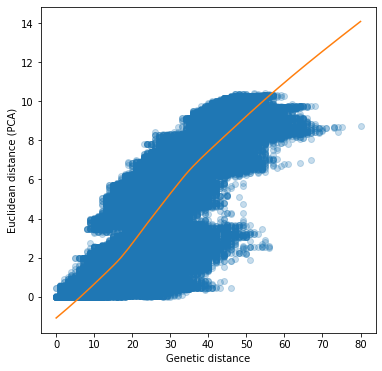

In [19]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("results/scatterplot_pca.csv",index_col=0)
metadata_PCA = pd.read_csv("results/scatterplot_pca_metadata.csv", index_col=0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (metadata_PCA["pearson_coef"].values.tolist()[0]))

sns.despine()

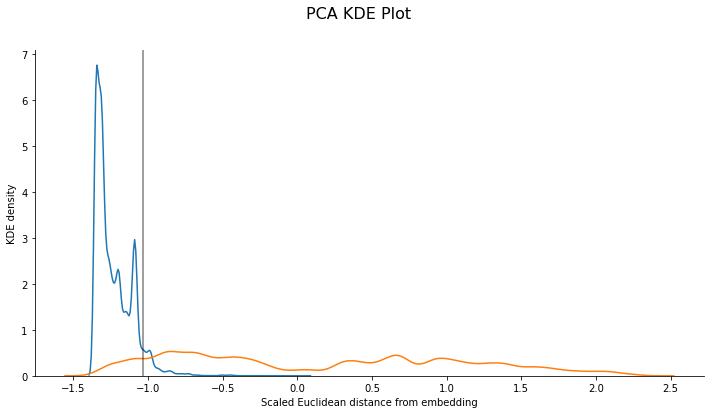

In [166]:
PCA_KDE_df = pd.read_csv("results/KDEDensity_pca.csv",index_col=0)
PCA_KDE_metadata_df = pd.read_csv("results/KDEDensity_pca_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [20]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)

In [21]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [22]:
merged_mds_df

strain      mds1       mds2       mds3       mds4  \
0        A/Brisbane/280/2016  9.366593  -4.829428  -2.520610  -0.674660   
1        A/Brisbane/302/2016  7.813673  -6.091877  -2.762770   0.622488   
2      A/California/122/2016  7.881038  -4.872017  -2.679753  -0.585493   
3          A/NewYork/57/2016  5.082181  -5.553408  -1.591304   0.724537   
4           A/Texas/178/2016  5.938972  -4.661972   1.261700   0.296396   
..                       ...       ...        ...        ...        ...   
718         A/Kenya/013/2017 -0.145332  -6.042586  14.022813  -3.715884   
719     A/India/1736032/2017  0.370553  -7.923795  18.527353  -6.025272   
720     A/HongKong/3391/2017  0.879806   9.619426   5.800861  -0.272717   
721     A/India/1732610/2017 -3.502726  -1.573391  21.808578 -10.788169   
722  A/MUWRP-Uganda/579/2016  6.954204 -10.299970  -9.887419   7.504477   

          mds5       mds6       mds7       mds8       mds9      mds10  \
0     8.336892   9.772523   4.724903  32.950712  13.189683  -5.247350   
1     9.735036   9.204740   3.972762  29.672282  15.333590  -2.891182   
2     9.125404   9.200783   4.139201  30.545529  14.216184  -3.613876   
3     9.751956   9.889910   6.438125  28.316348  14.214024  -3.790411   
4    11.221225  10.832757   7.702048  31.543899  13.439230  -4.306839   
..         ...        ...        ...        ...        ...        ...   
718  -2.380440   7.989482  17.405052 -13.758967 -13.882736  -0.991251   
719  -6.023513  -2.177455   9.134541 -12.171144   5.373915  -5.248145   
720  -3.183034   8.683006 -14.108029   9.021089   1.835315  -8.127880   
721   0.915612  -5.601483   8.777847 -19.394043   1.882746 -18.649067   
722 -13.342713  17.985591   8.209984  27.295788  -1.114167   2.523767   

     mds_label     date     y clade_membership clade_membership_color  
0            0  2016.82    75            3c3.A                  3c3.A  
1            0  2016.83    74            3c3.A                  3c3.A  
2            0  2016.53    71            3c3.A                  3c3.A  
3            0  2016.18    70            3c3.A                  3c3.A  
4            0  2016.59    76            3c3.A                  3c3.A  
..         ...      ...   ...              ...                    ...  
718         -1  2017.19   971              A1b                  other  
719         -1  2017.79   999         A1b/135N               A1b/135N  
720         -1  2017.52   299               A3                     A3  
721         -1  2017.68  1000         A1b/135N               A1b/135N  
722         -1  2016.67     4              3c3                  other  

[723 rows x 16 columns]

In [23]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [24]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [25]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

In [ ]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("results/scatterplot_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

sns.despine()

In [ ]:
MDS_KDE_df = pd.read_csv("results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("results/KDEDensity_mds_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [26]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("results/embed_t-sne.csv",index_col=0)

In [27]:
TSNE_df

tsne_x     tsne_y  t-sne_label
strain                                                    
A/Alabama/14/2016       -10.995776 -11.735100            1
A/Idaho/34/2016         -11.013156 -11.638208            1
A/Texas/170/2016        -11.095798 -11.204186            1
A/Texas/48/2016         -11.095976 -11.204360            1
A/Texas/171/2016        -11.104440 -11.186708            1
...                            ...        ...          ...
A/Kenya/013/2017         43.832508   6.300787            7
A/India/1736032/2017     53.467133  -6.400957           15
A/HongKong/3391/2017      8.464830   7.132806            3
A/India/1732610/2017     50.070470  -4.760612           15
A/MUWRP-Uganda/579/2016 -13.446401  -9.100626            1

[1150 rows x 3 columns]

In [28]:
merged_tsne_df = TSNE_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [29]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [30]:
list_of_chart = linking_tree_with_plots_clickable(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

In [ ]:
total_df_TSNE = pd.read_csv("results/scatterplot_t-sne.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

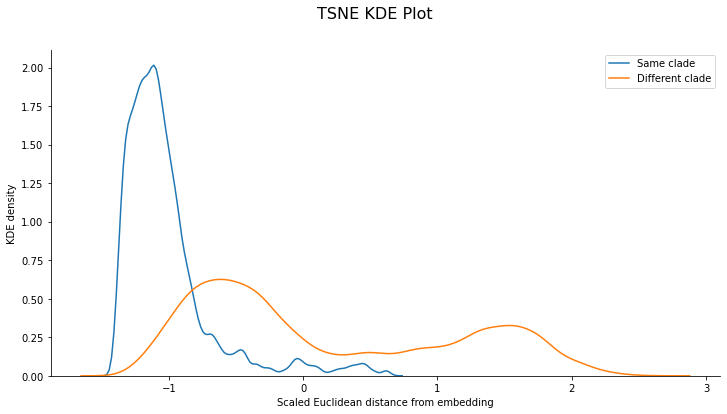

In [79]:
TSNE_KDE_df = pd.read_csv("results/KDEDensity_t-sne.csv",index_col=0)
TSNE_KDE_metadata_df = pd.read_csv("results/KDEDensity_t-sne_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [31]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)

In [32]:
merged_umap_df = UMAP_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [33]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [34]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

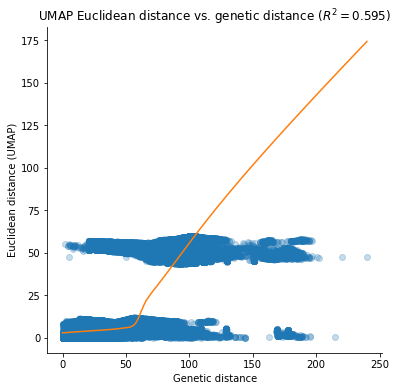

In [66]:
total_df_UMAP = pd.read_csv("results/scatterplot_umap.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

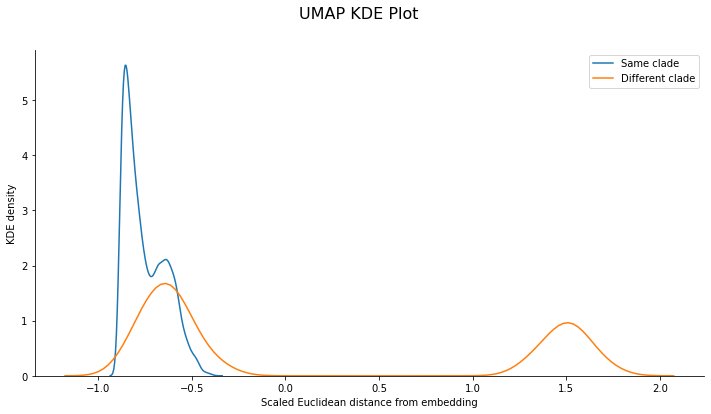

In [100]:
UMAP_KDE_df = pd.read_csv("results/KDEDensity_umap.csv",index_col=0)
UMAP_KDE_metadata_df = pd.read_csv("results/KDEDensity_umap_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [93]:
merged_df = node_df.merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [94]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [95]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("results/FullLinkedChartClickable" + "Zika" + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

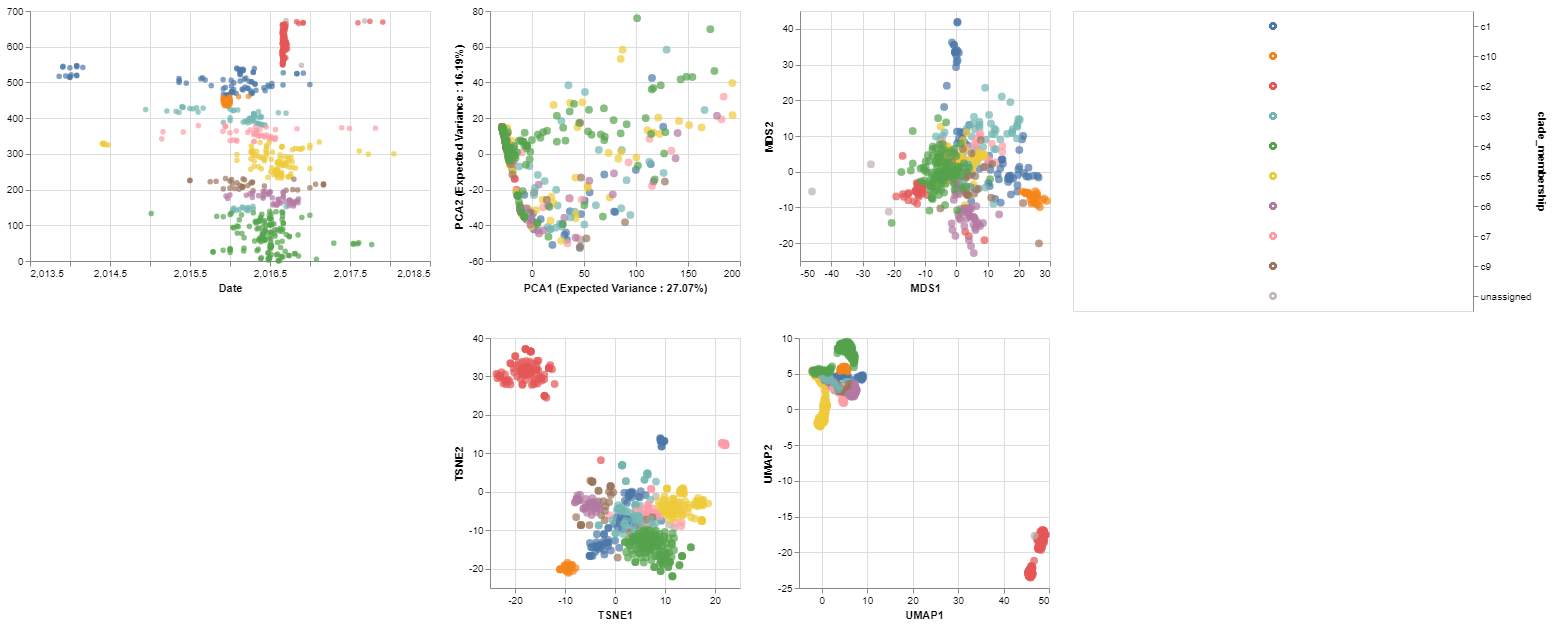

In [96]:
fullChart

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_PCA["pearson_coef"].values.tolist()[0]))

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))


sns.despine()
plt.savefig("../docs/FullScatterplot" + "Zika" + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [108]:
Genetic_KDE_df = pd.read_csv("results/KDEDensity_genetic.csv",index_col=0)
Genetic_KDE_metadata_df = pd.read_csv("results/KDEDensity_genetic_metadata.csv", index_col=0)

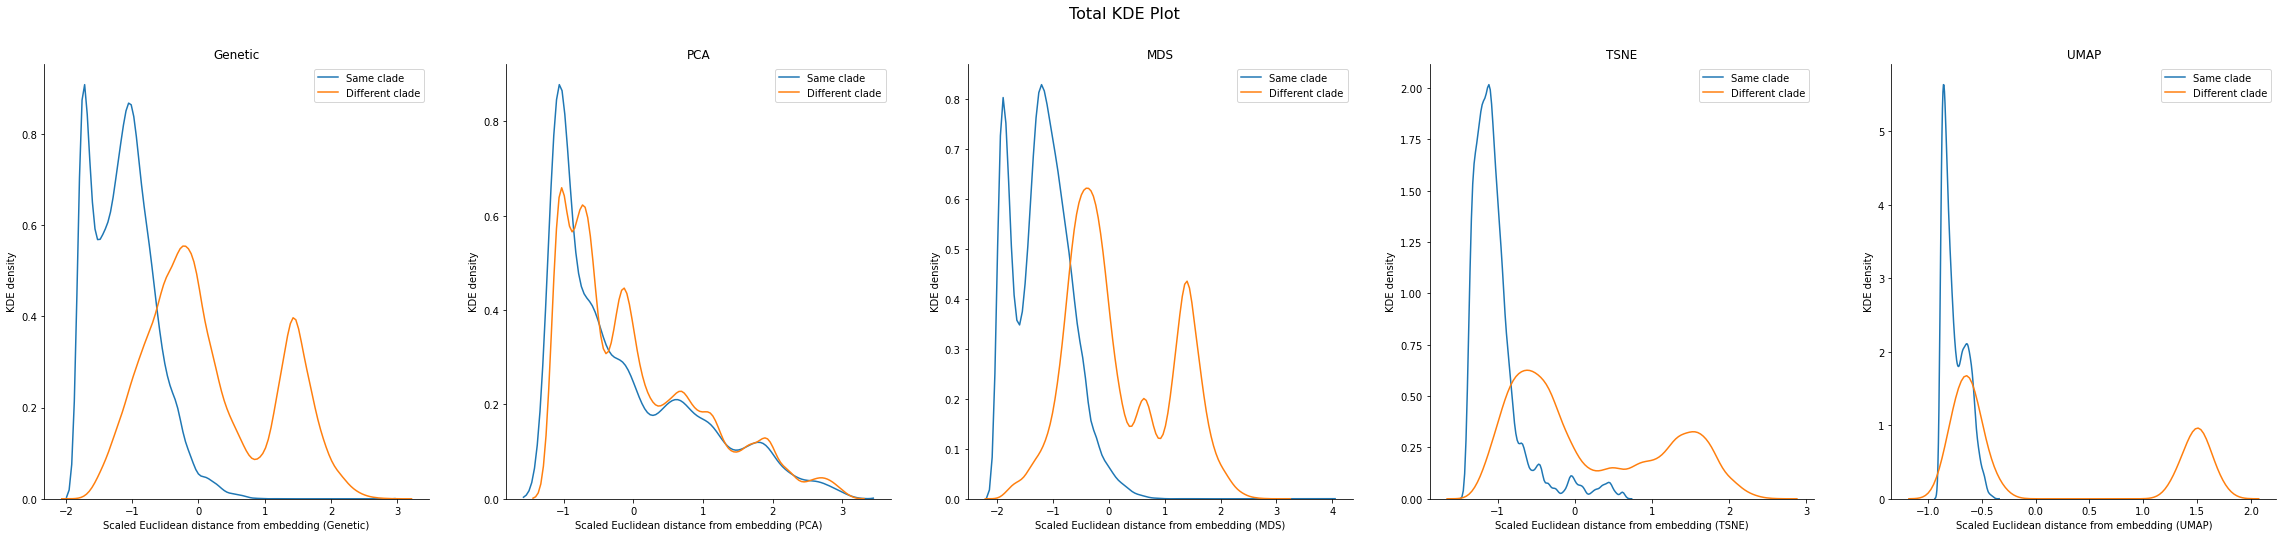

In [105]:
fig, axes = plt.subplots(1, 5, figsize=(40, 8))

#GENETIC 
ax = axes[0]
ax = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)
ax.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_title('Genetic')
ax.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax.set_ylabel("KDE density")

#PCA
ax = axes[1]
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)
ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_title('PCA')
ax.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax.set_ylabel("KDE density")

#MDS
ax = axes[2]
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)
ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_title('MDS')
ax.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax.set_ylabel("KDE density")

#TSNE
ax = axes[3]
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)
ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_title('TSNE')
ax.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax.set_ylabel("KDE density")

#UMAP
ax = axes[4]
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)
ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_title('UMAP')
ax.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FullKDEDensity" + "Zika" + ".png")

# Supplemental Figures

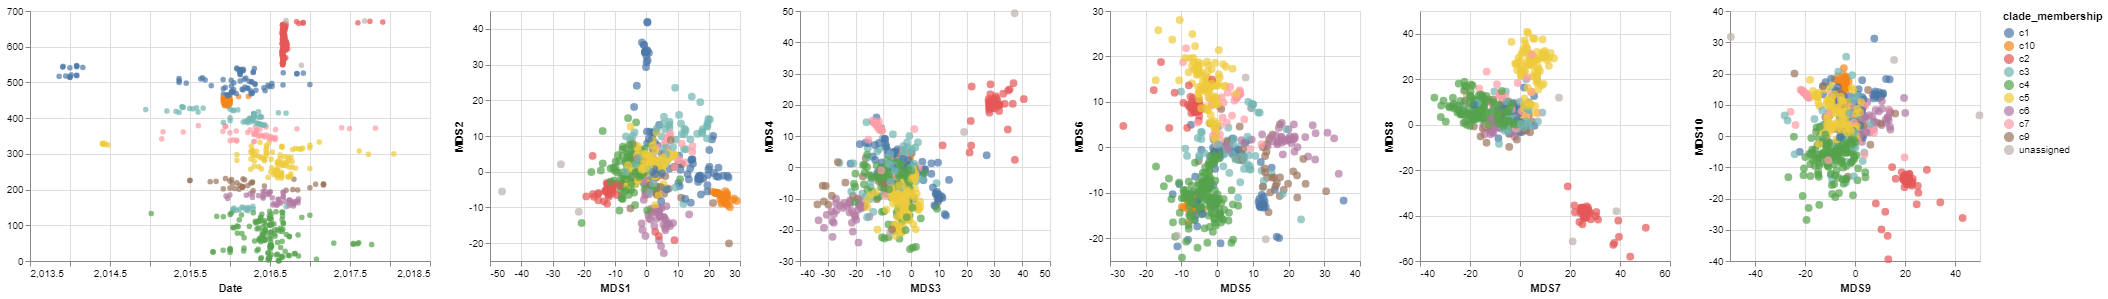

In [116]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

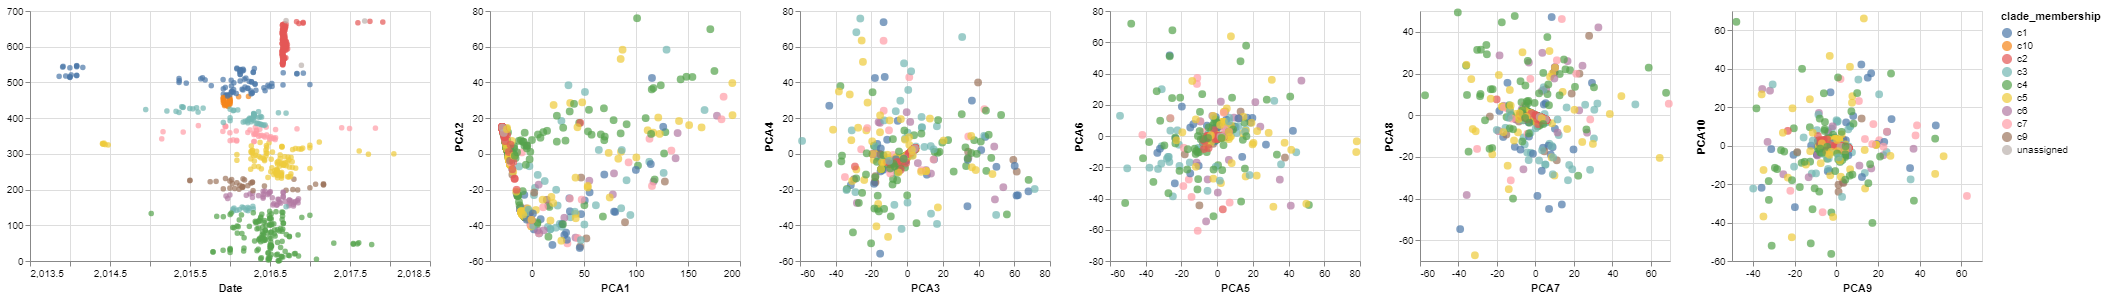

In [117]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]